In [1]:
from Kernels.LumpedCapacitor import *

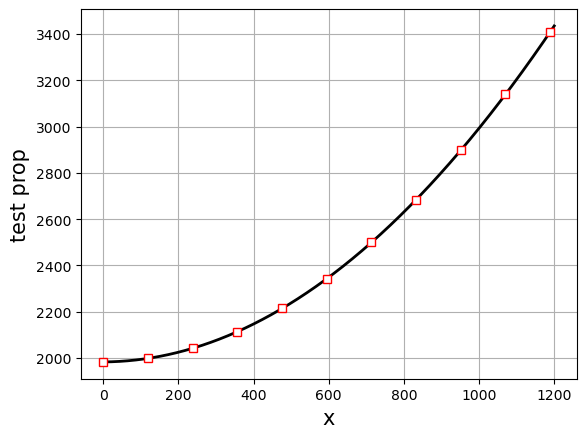

In [3]:
mat = LumpedMaterialProperty(name='test prop', function_coeffs=[1983, 0.01, 0.001])
mat.plot_prop(xMin=0, xMax=1200)